In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [15]:
x = 0

# Functions required

In [20]:
def get_margins(mu, N, M, t, T, delta):
    delta = 0.1
    val1 = N*(M+1)/2/delta
    val2 = t**3
    val = val1*val2
    # print(val)
    log_term = math.log(val)
    sqrt_term = log_term/2/T
    alpha = math.sqrt(sqrt_term)
    LCB = mu - alpha
    UCB = mu + alpha
    return LCB, UCB

In [21]:
def get_feasible_set(mu_th, UCB_attr):
    ## mu_attr will be an array with the current means of all attributes of the specific arm
    ## same for UCB and LCB things
    feasible_set = []
    ## here mu_attr would be a 2D array with all the means
    ## same for LCB (LCB_attr)
    n = len(UCB_attr)
    m = len(UCB_attr[0])
    for i in range (n):
        ## for each arm
        found = False
        UCB_min = min(UCB_attr[i])
        if (UCB_min >= mu_th):
            feasible_set.append(i)

    return feasible_set

In [22]:
def get_perfect_feasible_set(mu_th, LCB_attr):
    feasible_set = []
    ## here mu_attr would be a 2D array with all the means
    ## same for LCB (LCB_attr)
    # n = len(LCB_attr)
    n = len(LCB_attr)
    for i in range (n):
        ## for each arm
        LCB_min  = min(LCB_attr[i])
        if (LCB_min >= mu_th):
            feasible_set.append(i)

    return feasible_set

In [23]:
def get_potential_set(i_star_t, LCB_i_star, UCB):
    ## here UCB will be an array for UCB of means of all the arms
    potent = []
    for i in range(len(UCB)):
        if ((LCB_i_star <= UCB[i]) and (i != i_star_t)):
            potent.append(i)
    return potent

In [24]:
def best_arm(mu, feasible_set):
    ## for arms in feasible set, we need to find the arm with maximum mean
    best = feasible_set[0]
    for arm in feasible_set:
        if(mu[arm] >= mu[best]):
            best = arm
    return best

In [25]:
def intersection(lst1, lst2):
    temp = set(lst2)
    lst3 = [value for value in lst1 if value in temp]
    return lst3

In [26]:
def potentially_competitor_arm(UCB, feasible_set, potentially_best_arm):
    if (potentially_best_arm != feasible_set[0]):
        best = feasible_set[0]
    else:
        best = feasible_set[1]
    for arm in feasible_set:
        if (arm != potentially_best_arm):
            if((UCB[arm] > UCB[best])):
                best = arm
    # print("pot: ", potentially_best_arm, "ct: ", best)
    return best

In [27]:
def get_suboptimal_arm(mu_i_star, mu_i, arms_set):
    suboptimal = []
    for arms in arms_set:
        if (mu_i[arms] < mu_i_star):
            suboptimal.append(arms)

    return suboptimal

In [28]:
def difference(li1, li2):
    s = set(li2)
    temp3 = [x for x in li1 if x not in s]
    return temp3

# Oracle

In [42]:
class Oracle:
    def __init__(self, M, N, mu_th) -> None:
        self.M = M
        self.N = N
        arms = 5
        attributes = 2
        self.mu_ij = [[0 for i in range (attributes)] for j in range (arms)]
        self.mu_i = [0 for i in range (arms)]

        self.mu_th = mu_th
        
        self.mu_ij[0] = np.array([0.55, 0.6])        #0.575
        self.mu_ij[1] = np.array([x, 1])        #0.6 - risky and infeasible
        self.mu_ij[2] = np.array([0.4, 0.6])        #0.5
        self.mu_ij[3] = np.array([0.4, 0.5])        #0.45
        self.mu_ij[4] = np.array([0.1, 0.5])        #0.3 - infeasible

        for i in range (len(self.mu_i)):
            self.mu_i[i] = sum(self.mu_ij[i])/attributes

    def play(self, arm):
        reward = np.zeros(self.M)
        for j in range(len(reward)):
            p = self.mu_ij[arm][j]
            reward[j] = np.random.choice([0, 1], p=[1-p, p])
        return reward
    
    def H_index(self):
        self.i_star = 0                 ## best arm in the feasible set
        self.i_star_star = 1            ## best arm in suboptimal set

        self.delta_i = [0 for i in range (self.N)]
        self.delta_ij = [[0 for i in range (self.M)] for j in range (self.N)]
        self.delta_i_attr = [0 for i in range (self.N)]

         ### assume that always i_star is 0 ###
        for i in range (1, self.N):
            self.delta_i[i] = self.mu_i[self.i_star] - self.mu_i[i]
            self.delta_i_attr[i] = abs(min(self.mu_ij[i]) - self.mu_th)

        self.delta_i[self.i_star] = self.delta_i[self.i_star_star]
        self.delta_i_attr[self.i_star] = abs(min(self.mu_ij[self.i_star]) - self.mu_th)
        # print(self.delta_i_attr)

        all_arms = list(range(0, self.N))

        self.perfect_feasible = get_perfect_feasible_set(self.mu_th, self.mu_ij)
        self.suboptimal = get_suboptimal_arm(self.mu_i[self.i_star], self.mu_i, all_arms)
        self.risky = difference(all_arms, self.suboptimal)
        self.infeasible = difference(all_arms, self.perfect_feasible)                       ######################################3

        self.set1 = intersection(self.perfect_feasible, self.suboptimal)
        self.set2 = intersection(self.infeasible, self.risky)
        self.set3 = intersection(self.infeasible, self.suboptimal)

        h0_den = (min(self.delta_i[self.i_star]/2, self.delta_i_attr[self.i_star]))**2
        h0 = 1/h0_den

        h1 = 0
        for i in range (len(self.set1)):
            h1 += 4/(self.delta_i[self.set1[i]])**2

        h2 = 0
        for i in range (len(self.set2)):
            h2 += 1/(self.delta_i_attr[i])**2

        h3 = 0
        for i in range (len(self.set3)):
            h3 += 1/(max(self.delta_i[i]/2, self.delta_i_attr[i]))**2

        h_index = h0 + h1 + h2 + h3
        # print(self.delta_i_attr[1])

        return h_index

        

# Main function

In [30]:
def game(M, N, mu_th, delta):
    T_t = [0 for i in range (N)]
    t = 1
    theGame = Oracle(M, N, mu_th)

    h_idx = 0
    h_idx = theGame.H_index()

    mu_hat_i = [0 for i in range (N)]
    mu_hat_ij = [[0 for i in range (M)] for j in range (N)]

    LCB = [0 for i in range (N)]
    UCB = [0 for i in range (N)]

    LCB_attr = [[0 for i in range (M)] for j in range (N)]
    UCB_attr = [[0 for i in range (M)] for j in range (N)]

    T_unif = 20

    for j in range (T_unif):
        ## 20 times uniform exploration
        for i in range (N):
            reward_arm = theGame.play(i)
            for k in range (M):
                mu_hat_ij[i][k] = (mu_hat_ij[i][k] * T_t[i] + reward_arm[k])/(T_t[i] + 1)
            mu_hat_i[i] = sum(mu_hat_ij[i])/M
            T_t[i] += 1

    all_arms = list(range(0, N))
    feasible = list(range(0, N))
    t += N*T_unif

    ### further pulls

    while(True):
        ## arm wise margins
        for i in range (N):
            LCB[i], UCB[i] = get_margins(mu_hat_i[i], N, M, t, T_t[i], delta)

        ## attribute wise margins
        for i in range (N):
            for j in range (M):
                LCB_attr[i][j], UCB_attr[i][j] = get_margins(mu_hat_ij[i][j], N, M, t, T_t[i], delta)

        perfect_feasible = get_perfect_feasible_set(mu_th, LCB_attr)
        feasible = get_feasible_set(mu_th, UCB_attr)

        if(len(perfect_feasible) != 0):
            i_star_t = best_arm(mu_hat_i, perfect_feasible)

        if (len(feasible) != 0):
            i_t = best_arm(mu_hat_i, feasible)

        ## potential set is the set of arms which have more UCB than the  current best arm mean, irrespective of feasibility
        if (len(perfect_feasible) == 0):
            potential = all_arms
        else:
            potential = get_potential_set(i_star_t, LCB[i_star_t], UCB)
        
        pot_intersect_feas = intersection(potential, feasible)

        # print("Feasible: ", feasible, "Perfect feasible: ", perfect_feasible, "Potential: ", potential, "mu_hat for all", mu_hat_i, "UCB of all: ", UCB)
        #  "i_t: ", i_t, "i_star: ", i_star_t,

        ## Stopping criteria
        if (len(pot_intersect_feas) == 0):
            if(len(perfect_feasible) == 0):
                f_hat = 0
                i_out = N
            else:
                f_hat = 1
                i_out = i_t
            return i_out, f_hat, t, h_idx
        
        if (len(feasible) == 1):
            i_t = best_arm(mu_hat_i, feasible)
            arm_next1 = i_t
            arm_next2 = i_t
        else:
            i_t = best_arm(mu_hat_i, feasible)
            c_t = potentially_competitor_arm(UCB, feasible, i_t)
            arm_next1 = i_t
            arm_next2 = c_t

        ## play the 2 arms found above
        reward_arm1 = theGame.play(arm_next1)
        reward_arm2 = theGame.play(arm_next2)
        t += 2

        for j in range (M):
            mu_hat_ij[arm_next1][j] = (mu_hat_ij[arm_next1][j] * T_t[arm_next1] + reward_arm1[j])/(T_t[arm_next1] + 1)
            mu_hat_ij[arm_next2][j] = (mu_hat_ij[arm_next2][j] * T_t[arm_next2] + reward_arm2[j])/(T_t[arm_next2] + 1)
        mu_hat_i[arm_next1] = sum(mu_hat_ij[arm_next1])/M
        mu_hat_i[arm_next2] = sum(mu_hat_ij[arm_next2])/M
        T_t[arm_next1] += 1
        T_t[arm_next2] += 1


# Tests

## Single instance

Base Case: with 5 arms

In [17]:
# self.mu_ij[0] = np.array([0.9, 0.1])        #0.5
#         self.mu_ij[1] = np.array([0.1, 0.3])        #0.2
#         self.mu_ij[2] = np.array([0.2, 0.4])        #0.3
#         self.mu_ij[3] = np.array([0.4, 0.4])        #0.4
#         self.mu_ij[4] = np.array([0.5, 0.1])        #0.3

# mu_th = 0.3

In [32]:
N = 5
M = 2
best_arm_identified = []
N_iter = 10
count = [0 for i in range (N+1)]
samples_all = []
for i in range (N_iter):
    best_arm_guess, f, samples, h_idx = game(M, N, mu_th=0.3, delta=0.1)
    samples_all.append(samples)
    best_arm_identified.append(best_arm_guess)
    count[best_arm_guess] += 1
    print(count)


[0, 0, 0, 1, 0, 0]
[0, 0, 0, 2, 0, 0]
[0, 0, 0, 3, 0, 0]
[0, 0, 0, 4, 0, 0]
[0, 0, 0, 5, 0, 0]
[0, 0, 0, 6, 0, 0]
[0, 0, 0, 7, 0, 0]
[0, 0, 0, 8, 0, 0]
[0, 0, 0, 9, 0, 0]
[0, 0, 0, 10, 0, 0]


## Multiple Instances

#### Case 1a

In [52]:
# self.mu_ij[0] = np.array([x, 0.6])        #0.575 to 0.75
#         self.mu_ij[1] = np.array([0.5, 0.6])        #0.55
#         self.mu_ij[2] = np.array([0.2, 0.8])        #0.5
#         self.mu_ij[3] = np.array([0.4, 0.5])        #0.45
#         self.mu_ij[4] = np.array([0.5, 0.3])        #0.4

# mu_th = 0.3
# x from 0.55 to 0.9

In [35]:
N = 5
M = 2
N_iter = 10
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=0.3, delta=delta_ins)
        samples_all.append(samples)
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    time = h_idx * math.log(h_idx/delta_ins)
    time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    print("Done")


Done
Done
Done
Done
Done
Done
Done


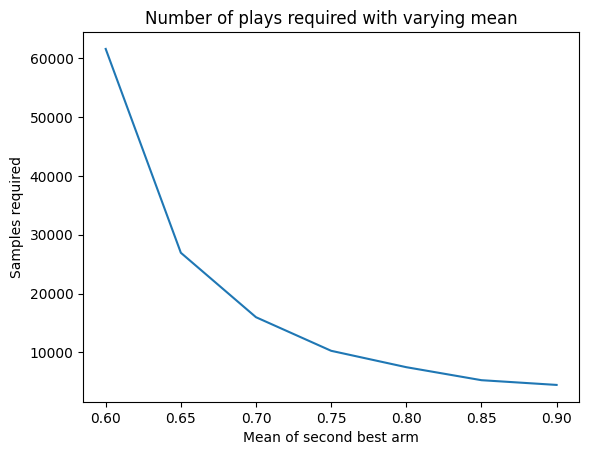

In [36]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

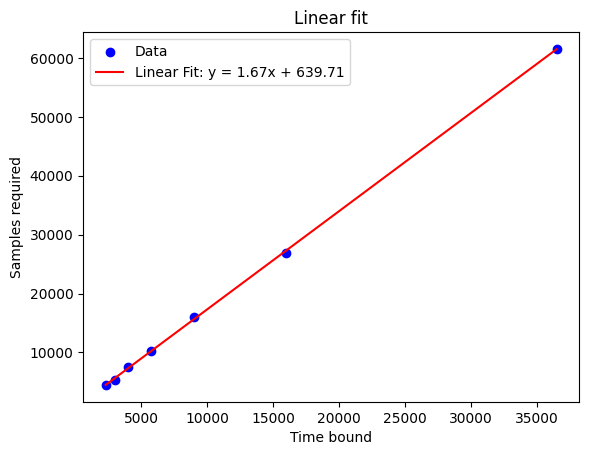

In [37]:
slope, intercept = np.polyfit(time_bound, samples_ins, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, samples_ins, label='Data', color='blue')
plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

#### Case 1b

In [ ]:
# self.mu_ij[0] = np.array([x, 1])        #0.75 to 
#         self.mu_ij[1] = np.array([0.4, 0.4])        #0.4
#         self.mu_ij[2] = np.array([0.2, 0.4])        #0.3
#         self.mu_ij[3] = np.array([0.1, 0.5])        #0.3
#         self.mu_ij[4] = np.array([0.5, 0.3])        #0.4

# mu_th = 0.45
# x from 0.5 to 0.7
# x, 1.5-x

# self.delta_i[self.i_star]/2 > self.delta_i_attr[self.i_star]
# Basic problem to be addressed is feasibility

In [39]:
N = 5
M = 2
N_iter = 10
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.5, 0.55, 0.6, 0.65, 0.7]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=0.45, delta=delta_ins)
        samples_all.append(samples)
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    time = h_idx * math.log(h_idx/delta_ins)
    time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    print("Done")


Done
Done
Done
Done
Done


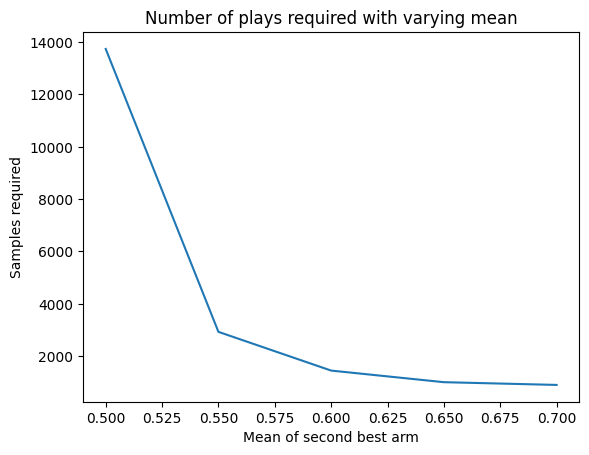

In [40]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

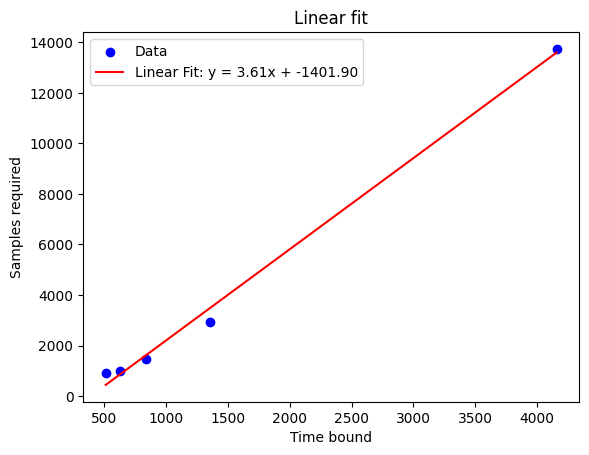

In [41]:
slope, intercept = np.polyfit(time_bound, samples_ins, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, samples_ins, label='Data', color='blue')
plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

In [20]:
print(time_bound)

[2420.8084928453086, 2339.823892710223, 2295.9475638492418, 2269.5315105943237, 2252.402758462854, 2240.666802044101]


#### Case 2

In [ ]:
# self.mu_ij[0] = np.array([x, 0.8])        #0.7 to 0.85 - feasible and best
#         self.mu_ij[1] = np.array([0.3, 1])        #0.65 - infeasible
#         self.mu_ij[2] = np.array([0.5, 0.6])        #0.55
#         self.mu_ij[3] = np.array([0.4, 0.5])        #0.45
#         self.mu_ij[4] = np.array([0.1, 0.5])        #0.3 - infeasible

# mu_th = 0.4

# delta i of arms in set (feasible intersection suboptimal)
# As delta_i increases, sample complexity will decrease

# let 3 arms be feasible
# one of the infeasible arm has highest total mean - this wont be suboptimal - not having this case
# total 3 suboptimal arms
# increase the mean of best arm -> delta_i will increase for all the arms
# vary x from 0.6 to 0.9


In [84]:
N = 5
M = 2
N_iter = 10
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=0.3, delta=delta_ins)
        samples_all.append(samples)
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    time = h_idx * math.log(h_idx/delta_ins)
    time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    print("Done")


Done
Done
Done
Done
Done
Done
Done


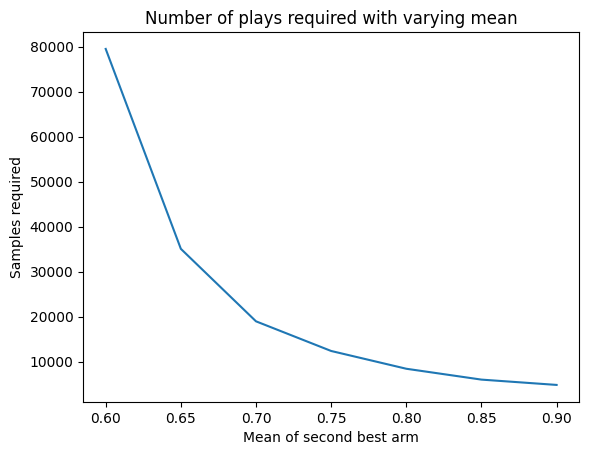

In [85]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

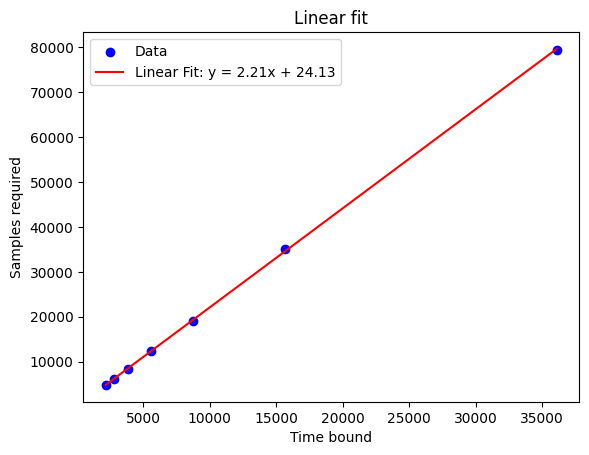

In [86]:
slope, intercept = np.polyfit(time_bound, samples_ins, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, samples_ins, label='Data', color='blue')
plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

#### Case 3

In [ ]:
# self.mu_ij[0] = np.array([0.55, 0.6])        #0.575
#         self.mu_ij[1] = np.array([x, 1])        #0.6 - risky and infeasible
#         self.mu_ij[2] = np.array([0.4, 0.6])        #0.5
#         self.mu_ij[3] = np.array([0.4, 0.5])        #0.45
#         self.mu_ij[4] = np.array([0.1, 0.5])        #0.3 - infeasible

# mu_th = 0.5

# delta_i_attr of arms in set (infeasible intersection risky)
# As delta_i_attr increases, sample complexity will decrease
# risky - mean greater than the best arm, would be infeasible most probably

# x, 1.2 - x, x varying from 0.2 to 0.45

In [47]:
N = 5
M = 2
N_iter = 10
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.2, 0.25, 0.3, 0.4, 0.45]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=0.5, delta=delta_ins)
        samples_all.append(samples)
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    time = h_idx * math.log(h_idx/delta_ins)
    time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    print("Done")


Done
Done
Done
Done
Done


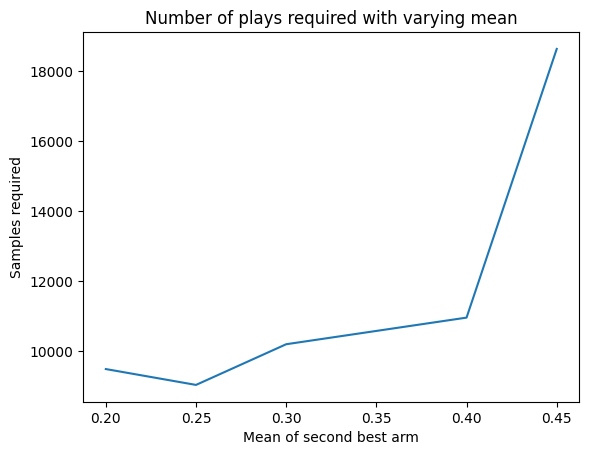

In [46]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

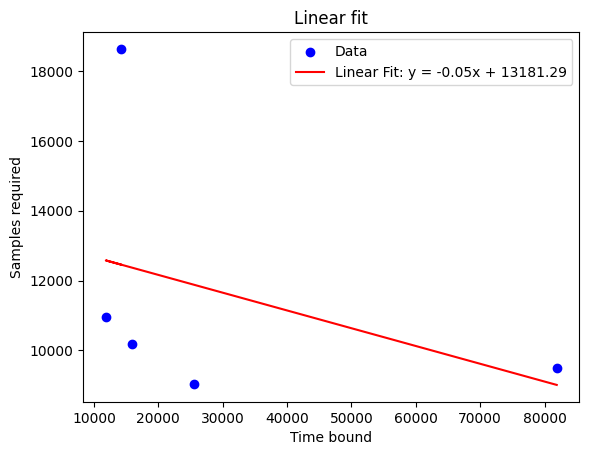

In [45]:
slope, intercept = np.polyfit(time_bound, samples_ins, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, samples_ins, label='Data', color='blue')
plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

#### Case 4a

In [ ]:
# self.mu_ij[0] = np.array([0.8, x])        #0.7 to 0.85
#         self.mu_ij[1] = np.array([0.3, 0.5])        #0.4 - infeasible
#         self.mu_ij[2] = np.array([0.4, 0.6])        #0.5 - infeasible
#         self.mu_ij[3] = np.array([0.8, 0.5])        #0.65
#         self.mu_ij[4] = np.array([0.2, 0.4])        #0.3 - infeasible

# mu_th = 0.4

# arms in set (infeasible intersection suboptimal)
# max(delta_i/2, delta_i_attr)
# delta_i/2 > delta_i_attr

# 3 arms infeasible, out of them one will be risky, 2 will be suboptimal
# x varies from 0.6 to 0.9

In [124]:
N = 5
M = 2
N_iter = 10
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=0.4, delta=delta_ins)
        samples_all.append(samples)
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    time = h_idx * math.log(h_idx/delta_ins)
    time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    print("Done")


Done
Done
Done
Done
Done
Done
Done


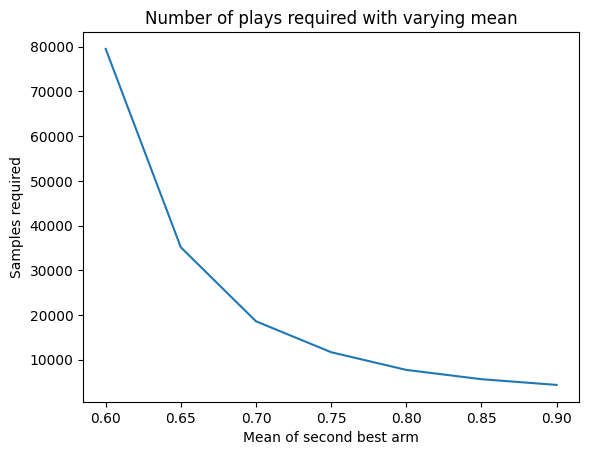

In [125]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

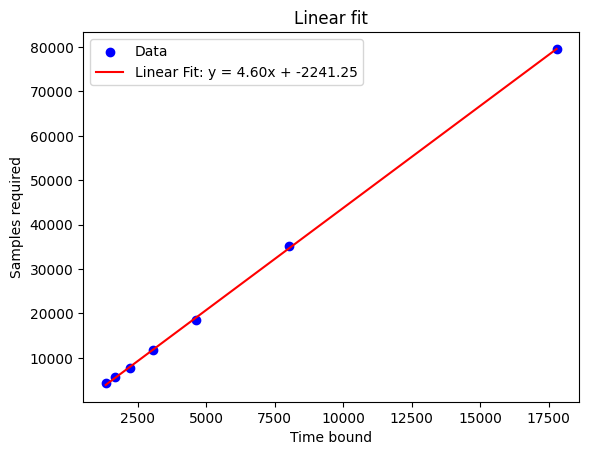

In [126]:
slope, intercept = np.polyfit(time_bound, samples_ins, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, samples_ins, label='Data', color='blue')
plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()

#### Case 4b

In [ ]:
# self.mu_ij[0] = np.array([0.5, 0.7])        #0.6
#         self.mu_ij[1] = np.array([x, 0.8])        #0.5 - infeasible
#         self.mu_ij[2] = np.array([0.3, 0.5])        #0.4 - infeasible
#         self.mu_ij[3] = np.array([0.5, 0.5])        #0.5
#         self.mu_ij[4] = np.array([0.2, 0.4])        #0.3 - infeasible

# mu_th = 0.4

# arms in set (infeasible intersection suboptimal)
# max(delta_i/2, delta_i_attr)
# delta_i/2 < delta_i_attr

# 3 arms infeasible, all of them suboptimal
# x, 1-x, x varying from 0.35 to 0.1
# x = 0.1,0.8 mean = 0.45, delta_i/2 = 0.075
# x = 0.3,0.8 mean = 0.55, delta_i/2 = 0.025
# x = 0.35, 0.8, mean = 0.575, delta_i/2 = 0.0125



In [22]:
N = 5
M = 2
N_iter = 10
delta_ins = 0.1

samples_ins = []
x_val = []
time_bound = []
prob_success = []

for x in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:
    count = [0 for i in range (N+1)]
    samples_all = []
    for i in range (N_iter):
        best_arm_guess, f, samples, h_idx = game(M, N, mu_th=0.4, delta=delta_ins)
        samples_all.append(samples)
        count[best_arm_guess] += 1

    samples_ins.append(sum(samples_all)/N_iter)
    x_val.append(x)
    time = h_idx * math.log(h_idx/delta_ins)
    time_bound.append(time)
    prob_success.append(count[0]/N_iter)
    print("Done")


Done
Done
Done
Done
Done
Done


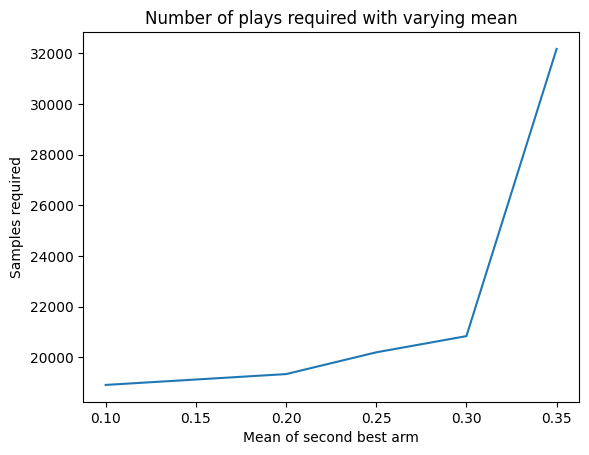

In [23]:
plt.title("Number of plays required with varying mean")
plt.xlabel("Mean of second best arm")
plt.ylabel("Samples required")
plt.plot(x_val, samples_ins)
plt.show()

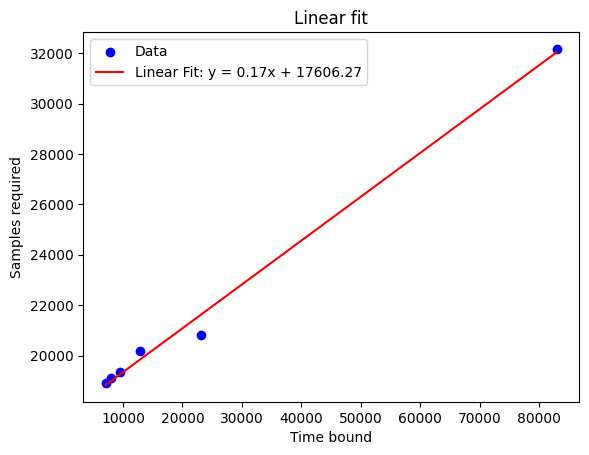

In [24]:
slope, intercept = np.polyfit(time_bound, samples_ins, 1)
time_bound_arr = np.array(time_bound)
regression_line = slope * time_bound_arr + intercept
plt.scatter(time_bound, samples_ins, label='Data', color='blue')
plt.plot(time_bound_arr, regression_line, label=f'Linear Fit: y = {slope:.2f}x + {intercept:.2f}', color='red')
plt.xlabel("Time bound")
plt.ylabel("Samples required")
plt.legend()
plt.title("Linear fit")
plt.show()